In [1]:
with open("tokens.txt") as file:
    tokens = file.read().splitlines()
HF_TOKEN_HERE = tokens[0]
API_TOKEN_HERE = tokens[1]
API_ENDPOINT_HERE = tokens[2]
MODEL = tokens[3]

In [2]:
dataset_name = "anneal"
results_path = f"tree_scores.{dataset_name}.json"

In [3]:
import os
import re
import json
import numpy as np
import pandas as pd
import openml
import smolagents
from huggingface_hub import login
import proxy_api_model
import prompting
import tree_agent
from sklearn.model_selection import train_test_split
from task import metric_func_by_task, get_task_variables, add_tabpfn_baseline
import dataset_descriptions

from build_tree_data_leak import CorruptionConfig, run_leakage_sweep, plot_scopeA_curves, _metric_higher_is_better, TrainValCorruptor, _stable_seed

In [ ]:
login(token=HF_TOKEN_HERE)
# V-- this uses a GPT-5 model over an API. Replace with https://smolagents.org/docs/agents-guided-tour/
model = proxy_api_model.ProxyAPIModel(
    model_id=MODEL,
    api_base=API_ENDPOINT_HERE,  # <-- https://your/openai-like/api/v1/chat/completions
    api_key=API_TOKEN_HERE,  # <-- use your token
    max_new_tokens=1024 * 8,
    # callback=lambda msg, **etc: print(  # print model thoughts before code
    # re.sub(r'<code>.*?</code>', '<code omitted>', msg.content, flags=re.DOTALL))
)

try:
    response = model.generate([{"role": "user", "content": "hello"}])
except Exception as e:
    print(e)

In [ ]:
# Load tabular benchmark
tabarena_version = "tabarena-v0.1"
benchmark_suite = openml.study.get_suite(tabarena_version)
task_ids = benchmark_suite.tasks
dataset_name_to_task_id = {}
for task_id in task_ids:
    task = openml.tasks.get_task(task_id)
    dataset = task.get_dataset()
    n_samples = dataset.qualities["NumberOfInstances"]
    if n_samples < 2_500:
        dataset_name_to_task_id[dataset.name] = task_id
        print(dataset.name, int(n_samples), task_id)

airfoil_self_noise 1503 363612
anneal 898 363614
Another-Dataset-on-used-Fiat-500 1538 363615
blood-transfusion-service-center 748 363621
concrete_compressive_strength 1030 363625
credit-g 1000 363626
diabetes 768 363629
Fitness_Club 1500 363671
hazelnut-spread-contaminant-detection 2400 363674
healthcare_insurance_expenses 1338 363675
Is-this-a-good-customer 1723 363682
Marketing_Campaign 2240 363684
maternal_health_risk 1014 363685
qsar-biodeg 1054 363696
QSAR_fish_toxicity 907 363698
website_phishing 1353 363707
MIC 1699 363711


In [ ]:
cfg = CorruptionConfig(
    mild_mask_rate=0.05,
    mild_noise_std=0.03,
    mild_scale_low=0.8,
    mild_scale_high=1.2,
    mild_rotate_frac=0.3,
    some_shuffle_col_frac=0.5,
)

df = run_leakage_sweep(
    dataset_name=dataset_name,
    model=model,
    n_repeats=3,                       # budget knob
    noise_levels=[0, 1, 2, 3],
    metadata_modes=["true", "none", "wrong"],
    corruption_cfg=cfg,
    results_jsonl_path=results_path.replace(".json", ".jsonl"),

    openml=openml,
    dataset_name_to_task_id=dataset_name_to_task_id,
    get_task_variables=get_task_variables,
    tree_agent=tree_agent,
    dataset_descriptions=dataset_descriptions,
    prompting=prompting,
    metric_func_by_task=metric_func_by_task,
)


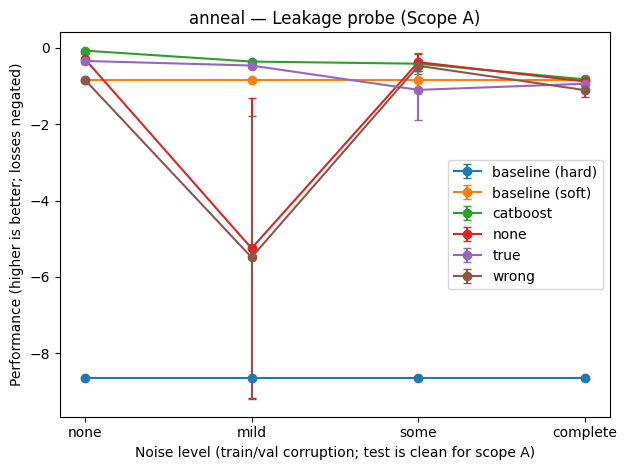

In [12]:
df = pd.read_csv("tree_scores.anneal.csv")
plot_scopeA_curves(df, title=f"{dataset_name} — Leakage probe (Scope A)")